# Long Short Term Memory

## Importing Necessary Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop

import pickle
import heapq

## Importing Dataset

In [5]:
text= open('1661-0.txt',encoding='UTF-8').read().lower()
print('corpus length:', len(text))

corpus length: 581883


## Data Preprocessing

In [6]:
# To tokenize the Sentence using a Regular String Expression

tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [7]:
# To find the unique words from the Tokenized text

unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [8]:
# Segregating the Words

WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [9]:
# Splitting Dataset

X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [11]:
# Sequential Model

model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [12]:
# Display the summary of the build model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               4264960   
                                                                 
 dense (Dense)               (None, 8201)              1057929   
                                                                 
 activation (Activation)     (None, 8201)              0         
                                                                 
Total params: 5,322,889
Trainable params: 5,322,889
Non-trainable params: 0
_________________________________________________________________


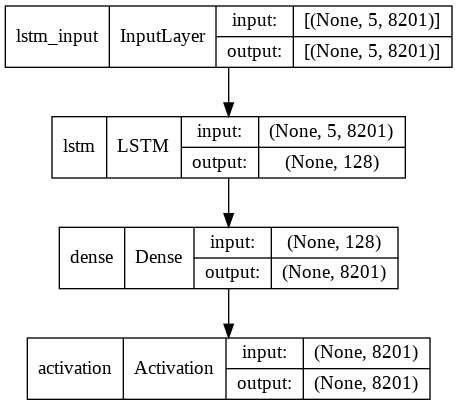

In [13]:
# Display the LSTM Neural Network model pictorially

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [14]:
# Fitting the model on the Training Dataset

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/2
811/811 [==============================] - 31s 31ms/step - loss: 6.0083 - accuracy: 0.1070 - val_loss: 7.0219 - val_accuracy: 0.1018
Epoch 2/2
811/811 [==============================] - 24s 29ms/step - loss: 5.7726 - accuracy: 0.1467 - val_loss: 7.9293 - val_accuracy: 0.1001


## Saving the Model

In [15]:
# Saving the history and the Model in .h5 and .p file extension

model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [16]:
# Preparing the Input Text

def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [17]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

## Prediction (Next Word)

In [18]:
# Function to predict the Next word

def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [22]:
# Next Word Prediction in Action

q =  "Light the candle instead of cursuing darkness"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  I like to play
Sequence:  i like to play
i
like
to
play
next possible words:  ['of', 'in', 'to', 'and', 'a']


## Summary

- We have build a LSTM model and fitted the model for just 2 epochs considering the amount of computational time it takes to run.
- With this model we are able to achieve a decent amount of accuracy which is appreciable.
- Suppose we have access to more resources like GPU and TPU so that the model could be trained still then the predictions that we will be achieving will be still more great and appreciable.